In [84]:
source("/frazer01/projects/CEGS/analysis/hla_type_1kgp/script/functions_hla_type.R")


In [167]:
dir.create("pipeline/beagle"                  , showWarnings = FALSE)
dir.create("pipeline/beagle/processing"       , showWarnings = FALSE)
dir.create("pipeline/beagle/ukbb"             , showWarnings = FALSE)
dir.create("pipeline/beagle/ukbb_vars_in_1kgp", showWarnings = FALSE)


In [86]:
ukbb_pgen_prefix = paste(getwd(), "input/ukbb/snps", sep = "/")

# Divide UKBB individuals into bins
- VCF would be too big otherwise

In [159]:
ukbb_psam = fread("input/ukbb/snps.psam", sep = "\t", header = TRUE, data.table = FALSE)
ukbb_ids  = ukbb_psam[,1]
ukbb2bin  = data.frame(id = ukbb_ids, bin = ceiling((1:length(ukbb_ids)) / 10000))
bins      = sort(unique(ukbb2bin$bin))

In [160]:
fwrite(ukbb2bin, "pipeline/beagle/ukbb2bin.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

# extract UKBB variants

In [165]:
command = paste("bcftools", "query",
                "-f", "'%ID\\t%AF\\n'",
                vcf_hla_types
               )

hla_real           = fread(cmd = command, sep = "\t", header = FALSE, data.table = FALSE)
colnames(hla_real) = c("hla_type", "af")


In [169]:
var_ids        = sort(unique(c(fread(paste(getwd(), "input/ukbb/snps.pvar", sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)[,3],
                               readLines(hla_types_list_file)
                              )))
var_ids        = var_ids[ grepl("^rs", var_ids) == TRUE | grepl("^6:", var_ids) == TRUE]
outfolder_ukbb = paste(getwd(), "pipeline/beagle/ukbb_vars_in_1kgp", sep = "/")
var_ids_file   = paste(outfolder_ukbb, "var_ids_ukbb.txt", sep = "/")

writeLines(c(var_ids, hla_real$hla_type), var_ids_file, sep = "\n")

In [170]:
prefix_ukbb_vars = paste(outfolder_ukbb, "ukbb_vars", sep = "/")

In [171]:
command = paste("plink2_64", 
                "--vcf"    , vcf_phased,
                "--extract", var_ids_file,
                "--memory" , 64000,
                "--threads", 8,
                "--export" , "vcf", "bgz", 
                "vcf-dosage=DS-force",
                "--out"   , prefix_ukbb_vars
               )

system(command)

vcf_ukbb_vars = paste(prefix_ukbb_vars, "vcf.gz", sep = ".")
command       = paste("bcftools", "index", "-t", vcf_ukbb_vars)

system(command)



In [172]:
vcf_ukbb_vars

[1] "/frazer01/projects/CEGS/analysis/hla_type_1kgp/pipeline/beagle/ukbb_vars_in_1kgp/ukbb_vars.vcf.gz"

# Run imputation

In [211]:
run_hla_typing_qsub = function(bins, qsub = FALSE)
{
    sh_file = paste(getwd(), "pipeline/beagle/run_imputation.sh", sep = "/")
    
    writeLines(text = c("#!/usr/bin/sh",
                        "source /frazer01/home/matteo/.bashrc",
                        paste("Rscript", paste(paste(getwd(), "script", "run_imputation.R", sep = "/"),
                                               "--taskid"   , "$SGE_TASK_ID")
                             )
                       ), 
               con  = sh_file, 
               sep  = "\n\n")
    
    qsub_command = paste("qsub",
                         "-t", paste(1, "-", length(bins), ":1", sep = ""),
                         "-tc", 50, 
                         "-l" , "h_vmem=16G",
                         "-pe", "smp", 4,
                         "-o" , paste(getwd(), "pipeline/beagle/logs.out", sep = "/"),
                         "-e" , paste(getwd(), "pipeline/beagle/logs.err", sep = "/"),
                         sh_file
                        )
    
    message(qsub_command)
    if(qsub == TRUE){system(qsub_command)}
}

run_hla_typing_qsub(bins, TRUE)


qsub -t 1-49:1 -tc 50 -l h_vmem=16G -pe smp 4 -o /frazer01/projects/CEGS/analysis/hla_type_1kgp/pipeline/beagle/logs.out -e /frazer01/projects/CEGS/analysis/hla_type_1kgp/pipeline/beagle/logs.err /frazer01/projects/CEGS/analysis/hla_type_1kgp/pipeline/beagle/run_imputation.sh



In [158]:
vcf_phased

[1] "/frazer01/projects/CEGS/analysis/hla_type_1kgp/pipeline/hla_typing/vcf/phased.vcf.gz"

# Once imputation is done, combine into one single VCF file

In [223]:
vcf_file_list = paste0(getwd(), "/pipeline/beagle/processing/bin", bins, "/imputed_hla.vcf.gz")
vcf_file_list = vcf_file_list[ file.exists(vcf_file_list)]
vcf_file      = paste (getwd(),  "pipeline/beagle/ukbb/vcf_files.txt", sep = "/")

writeLines(vcf_file_list, vcf_file, sep = "\n")

In [224]:
merged_vcf = paste (getwd(),  "pipeline/beagle/ukbb/imputed.vcf.gz", sep = "/")
command    = paste("bcftools", "merge",
                   "-l" , vcf_file,
                   "-Oz",
                   "-o" , merged_vcf
                  )

system(command)

command = paste("bcftools", "index", "-t", merged_vcf)

system(command)


## then create pgen

In [225]:
prefix  = paste(getwd(), "pipeline/beagle/ukbb/imputed", sep = "/")
command = paste("plink2_64",
                "--vcf", merged_vcf,
                "--make-pgen",
                "--sort-vars",
                "--out", prefix
               )

#system(command)

In [226]:
prefix  = paste(getwd(), "pipeline/beagle/ukbb/imputed", sep = "/")
command = paste("plink2_64",
                "--vcf", merged_vcf,
                "--make-bed",
                "--out", prefix
               )

message(command)

plink2_64 --vcf /frazer01/projects/CEGS/analysis/hla_type_1kgp/pipeline/beagle/ukbb/imputed.vcf.gz --make-bed --out /frazer01/projects/CEGS/analysis/hla_type_1kgp/pipeline/beagle/ukbb/imputed



# Do some tests on HLA typing

In [227]:
ids_test        = ukbb2bin[ ukbb2bin$bin == 1, "id"]
ids_test        = paste(ids_test, ids_test, sep = "_")
vcf_imputed_hla = vcf_file_list[[1]]
command         = paste("bcftools", "query",
                        "-H",
                        #"-s", paste(ids_test, collapse = ","),
                        "-f", "'%ID\\t%AF[\\t%DS]\\n'",
                        vcf_imputed_hla
                       )

hla_imputed           = fread(cmd = command, sep = "\t", header = TRUE, data.table = FALSE)
colnames(hla_imputed) = sub(":DS", "", unlist(lapply(colnames(hla_imputed), function(x){unlist(strsplit(x, "]"))[[2]]})))
hla_imputed           = hla_imputed[,c("ID", "AF", ids_test)]
colnames(hla_imputed) = c("hla_type", "af", ids_test)
rownames(hla_imputed) = hla_imputed$hla_type


In [228]:
gene2hla = data.frame(hla_type = hla_imputed$hla_type, gene = unlist(lapply(hla_imputed$hla_type, function(x){unlist(strsplit(x, "\\."))[[1]]})))

In [229]:
gene2gt = as.data.frame(rbindlist(lapply(geneinfo$gene, function(gene)
{
    indata = colSums(hla_imputed[ hla_imputed$hla_type %in% gene2hla[ gene2hla$gene == gene, "hla_type"], ids_test])
    out    = data.frame(gene = gene, 
                        gt0  = length(indata[ indata == 0]) / length(ids_test),
                        gt1  = length(indata[ indata == 1]) / length(ids_test),
                        gt2  = length(indata[ indata == 2]) / length(ids_test),
                        gt3  = length(indata[ indata >= 3]) / length(ids_test)
                       )
    
    return(out)
})), stringsAsFactors = FALSE)


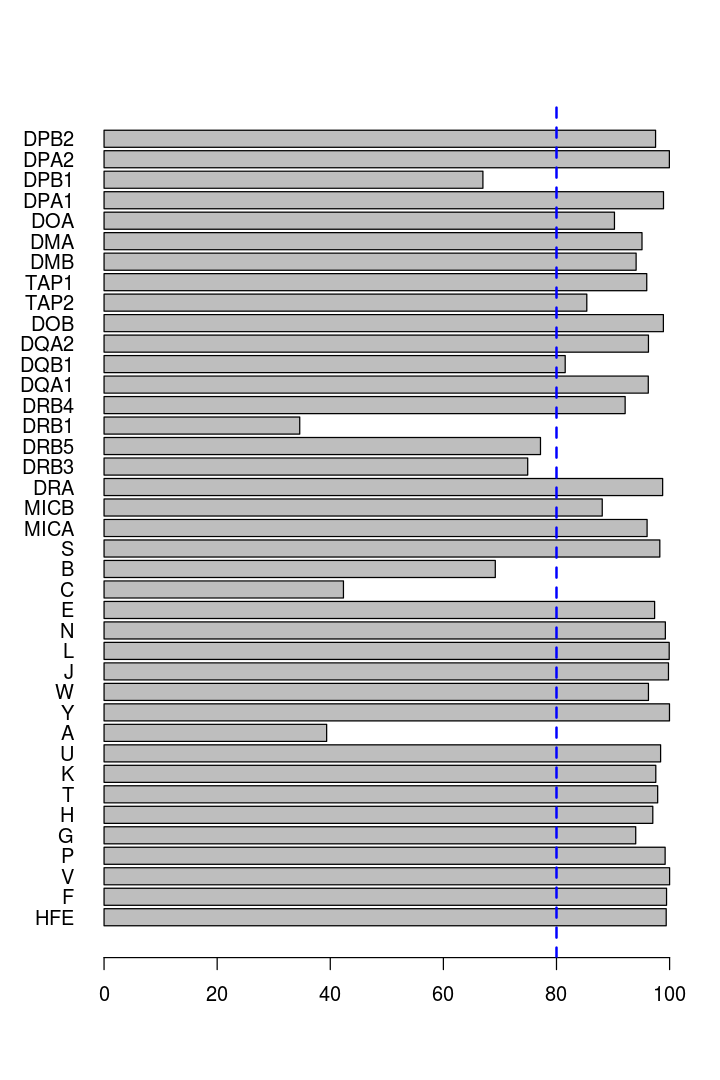

In [230]:
psize(6, 9)
barplot(gene2gt$gt2 * 100, names.arg = gene2gt$gene, horiz = TRUE, las = 1)
abline(v = 80, lty = "dashed", col = "#0000ff", lwd = 2)

In [231]:
gene2gt[ gene2gt$gt2 < 0.8, "gene"]
gene2gt[ gene2gt$gt2 < 0.9 & gene2gt$gt2 > 0.8, "gene"]


[1] "A"    "C"    "B"    "DRB3" "DRB5" "DRB1" "DPB1"

[1] "MICB" "DQB1" "TAP2"

In [232]:
gene2gt

gene,gt0,gt1,gt2,gt3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
HFE,0.0000,0.0049,0.9940,0.0011
F,0.0000,0.0045,0.9946,0.0009
V,0.0000,0.0000,1.0000,0.0000
P,0.0001,0.0078,0.9921,0.0000
G,0.0006,0.0591,0.9401,0.0002
H,0.0005,0.0284,0.9703,0.0008
T,0.0003,0.0208,0.9789,0.0000
K,0.0001,0.0240,0.9756,0.0003
U,0.0001,0.0157,0.9841,0.0001


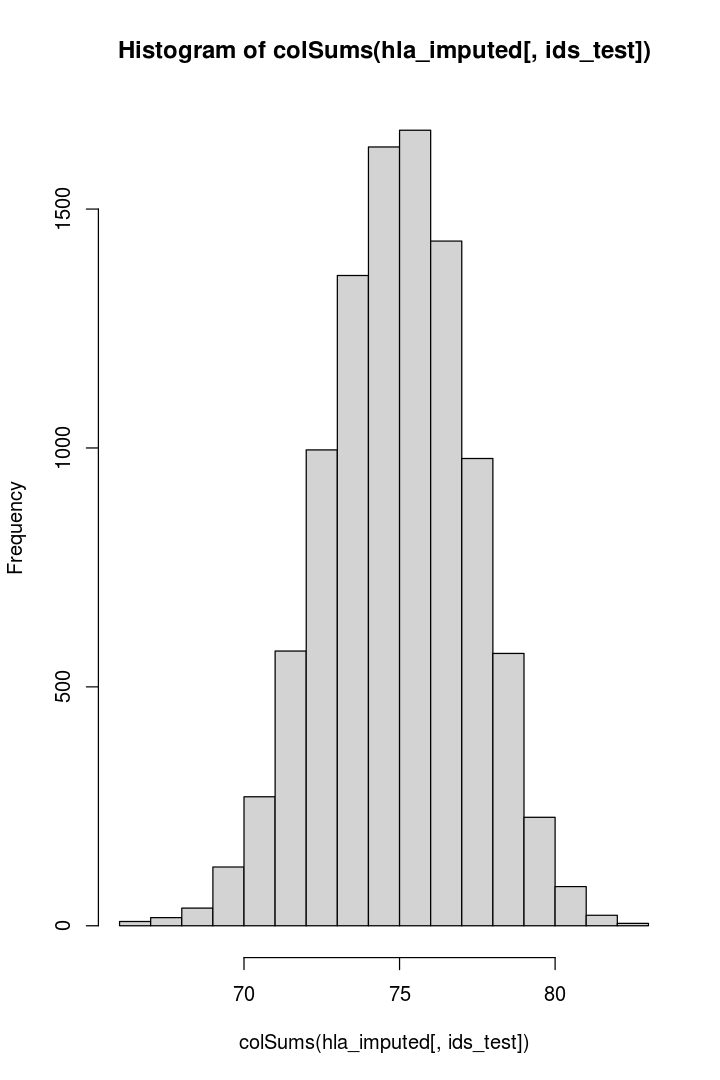

In [233]:
hist(colSums(hla_imputed[, ids_test]))

In [143]:
str(hla_imputed)

'data.frame':	2650 obs. of  10002 variables:
 $ ID             : chr  "HFE.001:01:02" "HFE.001:01:01" "HFE.001:01:03" "F.01:01:01:09" ...
 $ AF             : num  0.6105 0.3377 0.0564 0.1789 0.0609 ...
 $ 2497795_2497795: int  2 0 0 0 0 0 0 0 0 0 ...
 $ 2143467_2143467: int  2 0 0 0 0 0 0 0 0 0 ...
 $ 1288463_1288463: int  2 0 0 0 0 0 0 0 0 0 ...
 $ 2632032_2632032: int  2 0 0 0 0 0 0 0 0 0 ...
 $ 3667876_3667876: int  2 0 0 0 0 0 0 0 0 0 ...
 $ 3834788_3834788: int  2 0 0 0 0 0 0 0 0 0 ...
 $ 5659070_5659070: int  2 0 0 0 0 0 0 0 0 0 ...
 $ 3154457_3154457: int  2 0 0 0 0 0 0 0 0 0 ...
 $ 5713647_5713647: int  1 0 0 0 0 0 0 0 0 0 ...
 $ 2548437_2548437: int  2 0 0 0 0 0 0 0 0 0 ...
 $ 1218644_1218644: int  2 0 0 0 0 0 0 0 0 0 ...
 $ 3505384_3505384: int  2 0 0 0 0 0 0 0 0 0 ...
 $ 1228265_1228265: int  2 0 0 0 0 0 0 0 0 0 ...
 $ 3576974_3576974: int  2 0 0 0 0 0 0 0 0 0 ...
 $ 1028083_1028083: int  2 0 0 0 0 0 0 0 0 0 ...
 $ 5469668_5469668: int  2 0 0 0 0 0 0 0 0 0 ...
 $ 5619499_561

# SCRATCH

In [202]:
bin=1

In [208]:
filter_vcf_by_id = function(ids, vcf_in, vcf_out)
{
    command = paste("bcftools", "view",
                    "-s" , paste(ids, collapse = ","),
                    "-Oz",
                    "-o" , vcf_out,
                    vcf_in)
    
    system(command)

    command = paste("bcftools", "index", "-t", vcf_out)

    system(command)
}

command_convert_to_vcf = function(bin_file, outfolder, ukbb_pgen_prefix)
{
    vcf_unphased = paste(outfolder, "snps_unphased", sep = "/")
    
    command = paste("plink2_64", 
                    "--pgen"      , paste(ukbb_pgen_prefix, "pgen", sep = "."),
                    "--psam"      , paste(ukbb_pgen_prefix, "psam", sep = "."),
                    "--pvar"      , paste(ukbb_pgen_prefix, "pvar", sep = "."),
                    "--keep"      , bin_file ,
                    "--memory"    , 16000,
                    "--threads"   , 4,
                    "--export"    , "vcf", "bgz", "vcf-dosage=DS-force",
					"--maj-ref"   , "force", 
					#"--ref-allele", "force", vcf_snps, 4, 3, "'#'",
                    "--out"   , vcf_unphased
                   )
    message(command)
    system(command)
    
    vcf_unphased_gz = paste(vcf_unphased, "vcf", "gz", sep = ".")
    command         = paste("bcftools", "index", "-t", vcf_unphased_gz)

    system(command)
	
	vcf_phased = paste(outfolder, "snps.vcf.gz"                 , sep = "/")
	log_phased = paste(outfolder, "phased.log"                  , sep = "/")
	file_map   = paste(getwd()  , "input/phase/chr6.b37.gmap.gz", sep = "/")
	command    = paste("shapeit4", 
					   "--input" , vcf_unphased_gz, 
					   "--thread", 16,
					   "--map"   , file_map  ,
					   "--region", coord     ,
					   "--log"   , log_phased,
					   "--output", vcf_phased,
					   ""
					  )

	system(command)

	command = paste("bcftools", "index", "-t", vcf_phased)

	system(command)
    
    return(vcf_phased)
}

command_run_beagle = function(vcf_in, vcf_out, outfolder)
{
    map_file = "/frazer01/software/beagle-5.4/plink.GRCh37.map/plink.chr6.GRCh37.map"
    out_file = paste(outfolder, "imputed", sep = "/")
    command  = paste("/frazer01/software/jdk-16.0.1/bin/java", 
                     #"-Xss5m", 
                     "-Xmx32g", 
                     "-jar", "/frazer01/software/beagle-5.4/beagle.19Apr22.7c0.jar", 
                     paste("gt" , vcf_out   , sep = "="),
                     paste("ref", vcf_in    , sep = "="),
                     paste("map", map_file  , sep = "="),
                     paste("out", out_file  , sep = "="),
                     "nthreads=4",
                     "ne=500000",
                     "impute=true",
                     "seed=-99999",
                     "")

    system(command)
	
	return(out_file)
}

command_extract_hla_convert = function(imputed_vcf, outfolder)
{
    out_file = paste(outfolder, "imputed_hla", sep = "/")
    command  = paste("plink2_64", 
                     "--vcf"    , paste(imputed_vcf, "vcf.gz", sep = "."),
                     "--extract", hla_types_list_file,
                     "--memory" , 16000,
                     "--threads", 4,
                     "--export" , "vcf", "bgz", "--vcf-dosage=DS-force",
                     "--out"   , out_file
                    )
    
    system(command)
	
    command = paste("bcftools", "index", "-t", paste(out_file, "vcf", "gz", sep = "."))

    system(command)

}

impute = function(bin, ukbb2bin, ukbb_psam, ukbb_pgen_prefix)
{
    ids       = as.character(ukbb2bin[ ukbb2bin$bin == bin, "id"])
    outfolder = paste(getwd(), "pipeline/beagle/processing", paste0("bin", bin), sep = "/")
    bin_file  = paste(outfolder, "ids.txt", sep = "/")
    
    dir.create(outfolder, showWarnings = FALSE)
    
    fwrite(ukbb_psam[ ukbb_psam[,1] %in% ids,], bin_file, sep = "\t", col.names = TRUE, row.names = FALSE)
    
	vcf_ukbb_vars = paste(getwd(), "pipeline/beagle/ukbb_vars_in_1kgp", "ukbb_vars.vcf.gz", sep = "/")
    vcf           = command_convert_to_vcf     (bin_file     , outfolder, ukbb_pgen_prefix)
    message("AAAAAAAAAAAAAAAAAAAAAAAAA")
    imputed_vcf   = command_run_beagle         (vcf_ukbb_vars, vcf, outfolder)
    hla_out       = command_extract_hla_convert(imputed_vcf  , outfolder)
    
    return(hla_out)
}

ukbb2bin           = fread("pipeline/beagle/ukbb2bin.txt", sep = "\t", header = TRUE, data.table = FALSE)
rownames(ukbb2bin) = ukbb2bin$id
ukbb_psam          = fread("input/ukbb/snps.psam", sep = "\t", header = TRUE, data.table = FALSE)
ukbb_pgen_prefix   = paste(getwd(), "input/ukbb/snps", sep = "/")

impute(bin, ukbb2bin, ukbb_psam, ukbb_pgen_prefix)



plink2_64 --pgen /frazer01/projects/CEGS/analysis/hla_type_1kgp/input/ukbb/snps.pgen --psam /frazer01/projects/CEGS/analysis/hla_type_1kgp/input/ukbb/snps.psam --pvar /frazer01/projects/CEGS/analysis/hla_type_1kgp/input/ukbb/snps.pvar --keep /frazer01/projects/CEGS/analysis/hla_type_1kgp/pipeline/beagle/processing/bin1/ids.txt --memory 16000 --threads 4 --export vcf bgz vcf-dosage=DS-force --maj-ref force --out /frazer01/projects/CEGS/analysis/hla_type_1kgp/pipeline/beagle/processing/bin1/snps_unphased

AAAAAAAAAAAAAAAAAAAAAAAAA



[1] 255

In [77]:
ukbb2bin

id,bin
<int>,<dbl>
2497795,1
2143467,1
1288463,1
2632032,1
3667876,1
3834788,1
5659070,1
3154457,1
5713647,1


In [43]:
message(a)
message(vcf_phased)

/frazer01/projects/CEGS/analysis/hla_type_1kgp/pipeline/beagle/processing/bin1/snps.vcf.gz

/frazer01/projects/CEGS/analysis/hla_type_1kgp/pipeline/hla_typing/vcf/phased.vcf.gz



# impute with beagle